# Data Processing of EEG data

### Structure:

COGNITIVE_CODERS
* Raw gathered data
  * RightHandOpenCloseImagine
    * csv files
  * RightHandOpenClosePhysically
    * csv files
* Kaggle data
  * CupPickupImagine
    * csv files

### Current Datasets:
1) Right Hand physical : Gathered from MUSE on the Lethbridge site by team.
2) Right Hand imagined : Gathered from MUSE on the Lethbridge site by team.
3) Imagine picking up Cup: [link](https://www.kaggle.com/c/grasp-and-lift-eeg-detection/data?select=train.zip)
4) Leg datasets? 
5) Maybe Grasp and lift dataset

### Citations:
BenoniEdin, Klaus Greff, and Will Cukierski. Grasp-and-Lift EEG Detection. https://kaggle.com/competitions/grasp-and-lift-eeg-detection, 2015. Kaggle.

Install required packages using pip

In [14]:
#%pip install mne 
%pip install pandas -q
%pip install numpy -q
%pip install scipy -q
%pip install matplotlib -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Helper functions for preprocessing

In [15]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, welch,  resample, resample_poly
import matplotlib.pyplot as plt
import os

def add_sample_rows(data: pd.DataFrame, target_rows: int  = 15360, sampling_rate: int = 256) -> pd.DataFrame:
    ''' 
        Adds additional rows to the dataset to reach the target amount of rows. These additional rows are sampled from the rest of the data.

        Parameters:
        data (pd.DataFrame): Input DataFrame containing the EEG data. Assuming to have ['TP9', 'AF7', 'AF8', 'TP10', 'timestamps'] columns.
        target_rows (int): Desired number of rows in the output DataFrame
        sampling_rate (int): The sampling rate for the data. 
        
        Returns:
        pd.DataFrame: The input DataFrame with additional rows added
        
    '''
    # Calculate the number of missing samples
    missing_samples = target_rows - data.shape[0]
    if missing_samples == 0: return data
    
    # Randomly sample `missing_samples` rows from the entire dataset
    random_sampled_rows = data.sample(n=missing_samples, replace=True, random_state=42)

    # Get the new time values, which should continue from the last time value.
    # Start from the last time value and increase by missing_samples / sampling_rate
    last_time = data['timestamps'].iloc[-1]
    new_time = np.linspace(last_time, (last_time + missing_samples / sampling_rate), missing_samples + 1)[1:]

    # Add the new rows to the DataFrame
    new_df = pd.DataFrame({
        'timestamps': new_time,
        'TP9': random_sampled_rows['TP9'].values,
        'AF7': random_sampled_rows['AF7'].values,
        'AF8': random_sampled_rows['AF8'].values,
        'TP10': random_sampled_rows['TP10'].values
    })

    # Append the new rows to the original DataFrame
    df_extended = pd.concat([data, new_df], ignore_index=True)
    
    return df_extended

def standardize_time(data: pd.DataFrame, time_col :str = 'timestamps', outcol :str = 'timestamps', date_time: bool = False) -> tuple[pd.DataFrame, int]:
    '''
        Standardizes the time column from the input DataFrame to start with 0 and increment by sampling rate.
        
        Parameters: 
        data (pd.DataFrame): Input DataFrame containing the EEG data.
        time_col (str): Time column to change 
        outcol (str): What the output column is called
        date_time (bool): True if time_col is in datetime format
        
        Returns:
        pd.DataFrame: The input DataFrame with the standardized time column
        int: The sampling rate of the data
        
    '''
    # Calculate sampling rate
    if date_time:
        data[time_col] = pd.to_datetime(data[time_col])
        total_time = (data[time_col].iloc[-1] - data[time_col].iloc[0]).total_seconds()
    else: 
        total_time = (data[time_col].iloc[-1] - data[time_col].iloc[0])
        
    num_samples = len(data)
    fs  = num_samples / total_time
    
    # Standardize the time from 0 to 60
    standardized_time = np.linspace(0, (num_samples - 1) / fs, num_samples)

    # Add this new time array to dataframe
    data[outcol] = standardized_time
    
    return data, fs


### Process raw data gathered using MUSE hardware

In [21]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, welch,  resample, resample_poly
import matplotlib.pyplot as plt
import os

# Define frequency bands
bands = {
    'delta': (0.5, 4),
    'theta': (4, 7),
    'alpha': (8, 12),
    'beta': (13, 30),
    'full': (0.5, 50)
}
# Targeted channels for extraction 
eeg_channels = ['TP9', 'AF7', 'AF8', 'TP10']
# Name of folder containing the sub folders of data
directory_path = 'Raw gathered data'
# Number of rows we want to have in the output
target_rows = 15360
sub_folders = ['RightHandOpenClosePhysically', 'RightHandOpenCloseImagine']
output_folder = 'Processed Data'

# Load CSV data
for foldername in sub_folders:
    
    folder_path = os.path.join(directory_path, foldername)
    
    if os.path.isdir(folder_path):
        
        file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
        
        for idx, file in enumerate(file_list):
            
            # Load the CSV file and drop unnecessary columns
            file_path = os.path.join(folder_path, file)
            data = pd.read_csv(file_path, usecols=lambda column: column not in ['Unnamed: 0', 'Right AUX'])
            
            # Standardize the time in data
            data, samp_rate = standardize_time(data)
            
            # Resample the data
            # Drop all data past 15360
            data = data.iloc[:target_rows]
            # If we are missing rows to get to 15360, then add some samples
            data = add_sample_rows(data, sampling_rate  = samp_rate)
            
            # Save the new dataframe with filtered signals to a CSV
            if not os.path.exists(output_folder):
            # Create the directory
                os.makedirs(output_folder)
            
            output_filename = f'{output_folder}/{foldername}_{idx}.csv'
            data.to_csv(output_filename, index=False)
            print(f"Filtered data saved to {output_filename}")

Filtered data saved to Processed Data/RightHandOpenClosePhysically_0.csv
Filtered data saved to Processed Data/RightHandOpenClosePhysically_1.csv
Filtered data saved to Processed Data/RightHandOpenClosePhysically_2.csv
Filtered data saved to Processed Data/RightHandOpenClosePhysically_3.csv
Filtered data saved to Processed Data/RightHandOpenClosePhysically_4.csv
Filtered data saved to Processed Data/RightHandOpenClosePhysically_5.csv
Filtered data saved to Processed Data/RightHandOpenClosePhysically_6.csv
Filtered data saved to Processed Data/RightHandOpenClosePhysically_7.csv
Filtered data saved to Processed Data/RightHandOpenCloseImagine_0.csv
Filtered data saved to Processed Data/RightHandOpenCloseImagine_1.csv
Filtered data saved to Processed Data/RightHandOpenCloseImagine_2.csv
Filtered data saved to Processed Data/RightHandOpenCloseImagine_3.csv
Filtered data saved to Processed Data/RightHandOpenCloseImagine_4.csv
Filtered data saved to Processed Data/RightHandOpenCloseImagine_5.

### Process data from the kaggle dataset " "
Since the dataset contains data from various lengths, its processed into 15360 row chunks. Depending on the sampling rate this is 15360 / sampling rate seconds. \
Additionally, the additional rows that did not fit into a full chunk will be ignored since it would just be the last part of the experiment.

In [17]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, welch, resample, resample_poly
import matplotlib.pyplot as plt
import os

# Define frequency bands
bands = {
    'delta': (0.5, 4),
    'theta': (4, 7),
    'alpha': (8, 12),
    'beta': (13, 30),
    'full': (0.5, 50)
}
eeg_channels = ['TP9', 'AF7', 'AF8', 'TP10']
directory_path = 'Kaggle data'

chunk_size = 15360
# Number of rows we want to have in the output
target_rows = 15360
sub_folders = ['CupPickupImagine']
output_folder = 'Processed Imagine Cup'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
    
for foldername in sub_folders:
    
    folder_path = os.path.join(directory_path, foldername)
    
    if os.path.isdir(folder_path):
        
        file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
        
        for idx, file in enumerate(file_list):
            
            file_path = os.path.join(folder_path, file)
            data = pd.read_csv(file_path, usecols= lambda column: column in ['TimeStamp', 'RAW_TP9', 'RAW_AF7','RAW_AF8','RAW_TP10'])\
                .rename(columns={'RAW_AF8': 'AF8', 'RAW_AF7': 'AF7', 'RAW_TP10': 'TP10', 'RAW_TP9': 'TP9' })
                
            # Drop all rows with missing data
            data = data.dropna()

            # Standardize the time in data to start from 0
            data, fs = standardize_time(data, 'TimeStamp' , 'timestamps', True)
            
            
            # Split the data into chunks 
            num_chunks = (len(data) // chunk_size)
            
            
            # Save the new dataframe with filtered signals to a CSV
            for i in range(num_chunks):
                output_filename = f'{output_folder}/{foldername}_{idx}_{i}_{round(fs)}HZ.csv'
                start_row = i * chunk_size
                end_row = start_row + chunk_size
                chunk = data.iloc[start_row:end_row].drop(columns=['TimeStamp'])
                chunk.to_csv(output_filename, index=False)

### Process Grasp and lift dataset

In [43]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, welch, resample, resample_poly
import matplotlib.pyplot as plt
import os

# Define frequency bands
bands = {
    'delta': (0.5, 4),
    'theta': (4, 7),
    'alpha': (8, 12),
    'beta': (13, 30),
    'full': (0.5, 50)
}
directory_path = 'Grasp and lift'

chunk_size = 15360
# Number of rows we want to have in the output
target_rows = 15360
sub_folders = ['train']
output_folder = 'Processed grasp and lift'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
# Load the dataset
for foldername in sub_folders:
    
    folder_path = os.path.join(directory_path, foldername)
    
    if os.path.isdir(folder_path):
        
        datafile_list = [file for file in os.listdir(folder_path) if file.endswith('data.csv')]
        eventfile_list = [file for file in os.listdir(folder_path) if file.endswith('events.csv')]
        
        for idx, file in enumerate(eventfile_list):
            
            file_path = os.path.join(folder_path, file)
            event_df = pd.read_csv(file_path)
            
            # data file_path 
            data_file = os.path.join(folder_path, datafile_list[idx])
            data_df = pd.read_csv(data_file)
            
            # Find the first index where HandStart == 1
            start_index = event_df[event_df['HandStart'] == 1].index.min()

            # Find the first index where BothReleased changes from 1 to 0
            end_index = event_df[(event_df['BothReleased'].shift(1) == 1) & (event_df['BothReleased'] == 0)].index.min()
            print(start_index, end_index)
            # Subset the DataFrame
            subset_df = event_df.loc[start_index:end_index]
            current_length = end_index - start_index + 1

            # Print or use the subset DataFrame
            # Check if the current length is less than 15,360 rows
            rows_needed = 15360 - subset_df.shape[0]
            
            if rows_needed > 0:
                # Push start_index back and end_index forward by half the rows needed (evenly distributed if possible)
                extend_start = min(start_index, rows_needed // 2)  # Ensure we do not go below index 0
                extend_end = min(len(event_df) - end_index - 1, rows_needed - extend_start)  # Ensure we stay within DataFrame bounds

                # Adjust start_index and end_index
                start_index -= extend_start
                end_index += extend_end

                # Ensure the new length is exactly 15,360 rows
                #end_index = start_index + 15360 - 1
            
            # Ensure the final range has exactly 15,360 rows
            subset_df = event_df.loc[start_index:end_index]
            print(start_index, end_index)
            # Join event_df with subset_df on 'id'
            joined_df = pd.merge(data_df, subset_df, on='id', how='inner')

            # Drop columns that are in subset_df from the joined DataFrame
            columns_to_drop = subset_df.columns.difference(['id'])  # Exclude 'id' column from being dropped
            final_df = joined_df.drop(columns=columns_to_drop, axis = 1)
            
            # calculate time using 500 HZ 
            sampling_interval = 1 / 500  # 0.002 seconds

            # Create the time column starting from 0 and incrementing by the sampling interval
            final_df['timestamps'] = final_df.index * sampling_interval
            final_df['timestamps'] = round(final_df['timestamps'], 5)
            # Drop the old 'id' column and reorder columns if needed
            final_df = final_df.drop(columns=['id'])
            
            # Save to CSV
            words = file.split('_')
            output_filename = f'{output_folder}/{words[0]}{words[1]}.csv'
            final_df.to_csv(output_filename, index=False)
            print(f"Filtered data saved to {output_filename}")
            
            
            
            

2530 5181
0 15359
Filtered data saved to Processed grasp and lift/subj10series1.csv
1207 4168
0 15359
Filtered data saved to Processed grasp and lift/subj10series2.csv
1236 4659
0 15359
Filtered data saved to Processed grasp and lift/subj10series3.csv
1215 3800
0 15359
Filtered data saved to Processed grasp and lift/subj10series4.csv
1255 3798
0 15359
Filtered data saved to Processed grasp and lift/subj10series5.csv
1208 3812
0 15359
Filtered data saved to Processed grasp and lift/subj10series6.csv
1210 3827
0 15359
Filtered data saved to Processed grasp and lift/subj10series7.csv
1163 3821
0 15359
Filtered data saved to Processed grasp and lift/subj10series8.csv
1388 4332
0 15359
Filtered data saved to Processed grasp and lift/subj11series1.csv
1490 4416
0 15359
Filtered data saved to Processed grasp and lift/subj11series2.csv
1921 4511
0 15359
Filtered data saved to Processed grasp and lift/subj11series3.csv
1244 4137
0 15359
Filtered data saved to Processed grasp and lift/subj11seri

# PLOTS

## Plotting what the gathered signal looks like

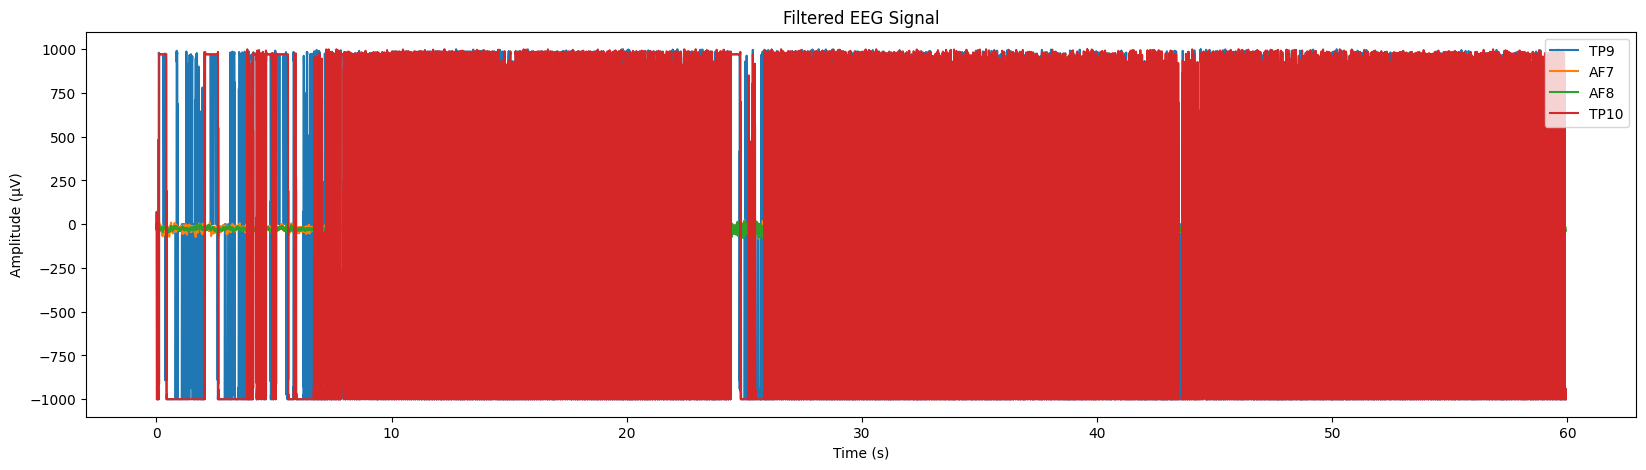

In [18]:
# view gathered signal 
file = 'Raw gathered data/RightHandOpenCloseImagine/recording_2024-11-15-21.57.20.csv'
raw = pd.read_csv(file, usecols=lambda column: column not in ['Unnamed: 0', 'Right AUX'])
pro_file = 'Processed Data/RightHandOpenCloseImagine_0.csv'
processed = pd.read_csv(pro_file, usecols=lambda column: column not in ['Unnamed: 0', 'Right AUX'])

plt.figure(figsize=(20, 5))
for i in ['TP9', 'AF7', 'AF8', 'TP10']:
    plt.plot(processed['timestamps'], processed[i], label = i)
    
plt.title('Filtered EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.show()

## Plotting Kaggle Muse Dataset

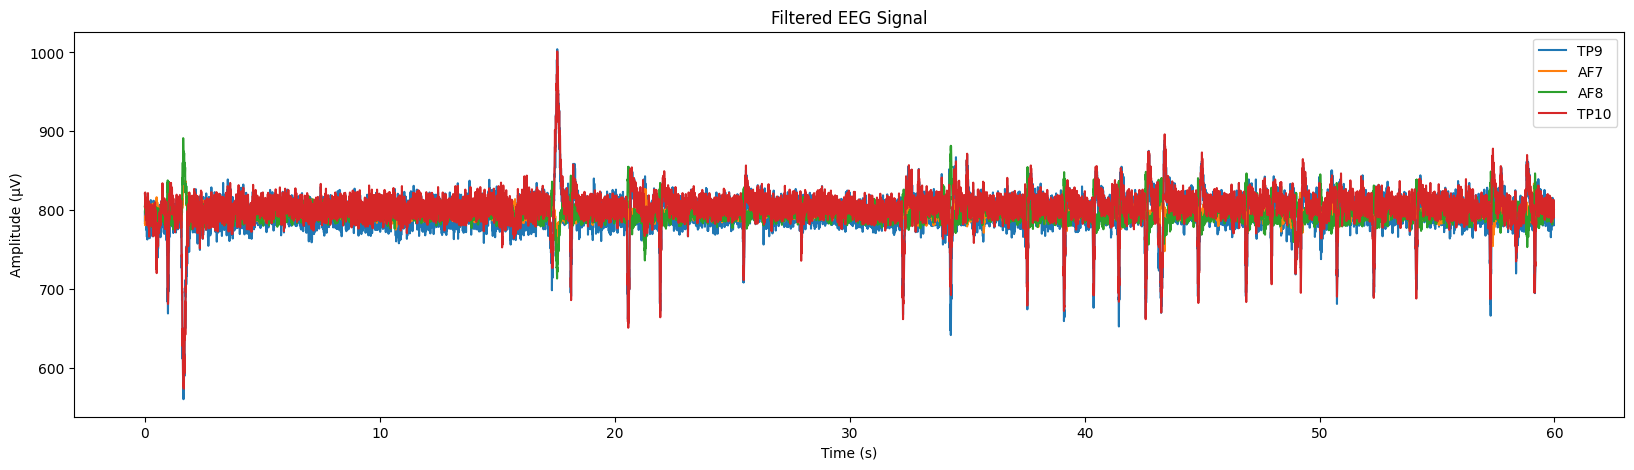

In [ ]:
# Add this new time array to your DataFrame
plt.figure(figsize=(20, 5))
processed = pd.read_csv('TESTTEST/CupPickupImagine_0_0_256HZ.csv')
for i in ['TP9', 'AF7', 'AF8', 'TP10']:
    plt.plot(processed['timestamps'], processed[i], label = i)

plt.title('Filtered EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.show()

### Plotting Grasp and lift dataset

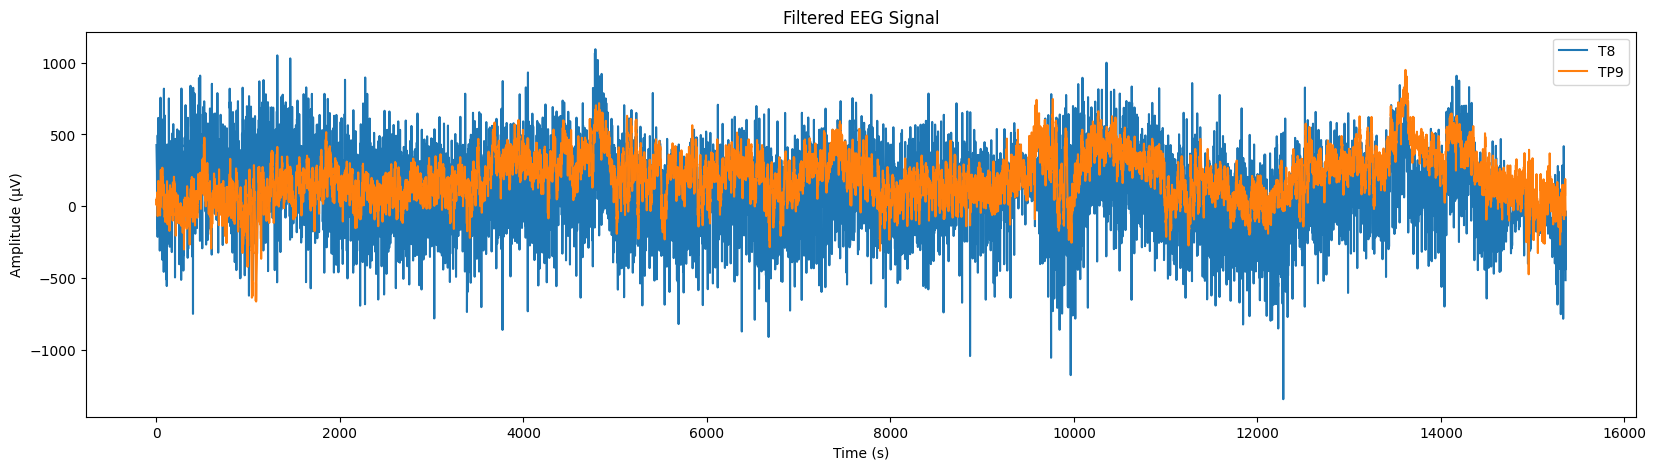

In [41]:
# Add this new time array to your DataFrame
plt.figure(figsize=(20, 5))
processed = pd.read_csv('Processed grasp and lift/subj12series5.csv', usecols = lambda x : x in ['T8','TP9'])
for i in ['T8','TP9']:
    plt.plot([x for x in range(processed.shape[0])], processed[i], label = i)

plt.title('Filtered EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.show()

### IGNORE

In [20]:


# Temp functions: not used 
## Was thinking of doing band filtering but should be beeter if we do it in model step?
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter a channel
# filtered_eeg = bandpass_filter(data['AF8'], 0.5, 4, fs)

# Filter data for each band and each channel
# for band, (lowcut, highcut) in bands.items():
#     for channel in eeg_channels:
#         filtered_signal = bandpass_filter(data[channel], lowcut, highcut, fs)
#         data[f'{channel}_{band}'] = filtered_signal
# Find the scaling factor for the resampling